## Прогноз рисков для беременных

Необходимо создать прогностическоую модель рисков беременных.

**Метрика**: на выбор  
**Особенности**: В последних ячейках необходимо вывести метрики и матрицу ошибок на трейне и тесте.

**Описание данных**:
Age: возраст в годах, когда женщина беременна.  
SystolicBP: верхнее значение артериального давления в мм рт. ст., важный показатель во время беременности.  
DiastolicBP: нижнее значение артериального давления в мм рт. ст., также значимый показатель во время беременности.  
BS: уровень глюкозы в крови, измеряемый в молярной концентрации, ммоль/л.  
HeartRate: нормальная частота сердечных сокращений в состоянии покоя, измеряемая в ударах в минуту.  
Risk Level: предсказанный уровень интенсивности риска во время беременности с учётом предыдущих показателей.  

<a id='К-содержанию'></a>  
**Содержание проекта**  
[Загрузка и предобработка данных](#Загрузка-и-предобработка-данных)  
[Генерация признаков и корреляционный анализ](#Генерация-признаков-и-корреляционный-анализ)  
[Разделение данных на обучающую и тестовую выборки](#Разделение-данных-на-обучающую-и-тестовую-выборки)  
[Создание моделей и обучение](#Создание-модели-LSTM-с-использованием-PyTorch-и-обучение)  
[Прогноз на тестовой выборке](#Прогноз-на-тестовой-выборке.-Расчет-метрик-качества)  
[Общий вывод](#Общий-вывод)  

In [1]:
%%capture
!pip install tensorflow
!pip install scikeras
!pip install catboost

In [2]:
#импортируем библиотеки перед началом проекта одним блоком
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# импортируем классы GridSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# загружаем модули для нейронной сети
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier


# загружаем функции для работы с метриками
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# зададим стандарт датафрейма перед загрузкой
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# вывод гистограммы и boxplot
def hist_box(data,column,hue=None):
    
    palette = sns.color_palette('hsv', n_colors=10)
    random_color = random.choice(palette)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 2))

    if hue == None:
        
        sns.histplot(data=data, x=column, bins=10, 
                     color=random_color,
                     alpha=0.6,
                     legend='auto', 
                     ax=axes[0])
    else:
        
        sns.histplot(data=data, x=column, bins=10, 
                     color=random_color,
                     alpha=0.6,
                     hue=hue, 
                     multiple='stack',
                     ax=axes[0])
        legend_labels = data[hue].unique()
        axes[0].legend(labels=legend_labels,title='Легенда', bbox_to_anchor=(1, 1), loc='upper left')

    sns.boxplot(x=data[column], color=random_color, ax=axes[1])
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show();

<a id='Загрузка-и-предобработка-данных'></a> 
## Загрузка и предобработка данных
[К содержанию](#К-содержанию) 

In [4]:
# импортируем данные
pth = 'Maternal Health Risk Data Set.csv'

if os.path.exists(pth):
    data = pd.read_csv(pth)
else:
    print(f'Файл {pth} не найден')

data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [5]:
# переименуем столбцы в нижний регист
data.columns = data.columns.str.lower()

# проверим данные на пропуски
print('Количество пропусков в датасете:\n', data.isna().sum(), sep='')

# проверим данные на дубликаты в индекске
print('\nКоличество дубликатов: ', data.duplicated().sum(),'\n')

# посмотрим на типы данных
print(data.info(),'\n')

Количество пропусков в датасете:
age            0
systolicbp     0
diastolicbp    0
bs             0
bodytemp       0
heartrate      0
risklevel      0
dtype: int64

Количество дубликатов:  562 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1014 non-null   int64  
 1   systolicbp   1014 non-null   int64  
 2   diastolicbp  1014 non-null   int64  
 3   bs           1014 non-null   float64
 4   bodytemp     1014 non-null   float64
 5   heartrate    1014 non-null   int64  
 6   risklevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None 



In [6]:
# убираем полные дубликаты, несмотря на то, что это почти половина датасета - они скорее помешают при обучении модели
data = data.drop_duplicates()

# посмотрим на единственный текстовый столбец на предмет опечаток
data['risklevel'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

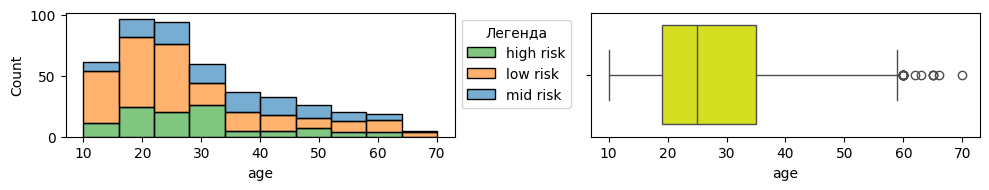

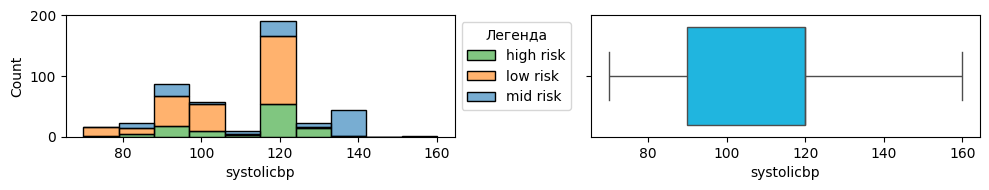

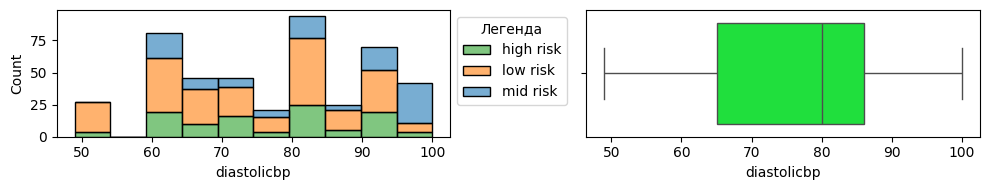

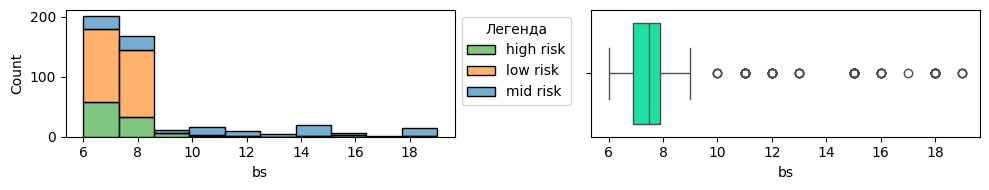

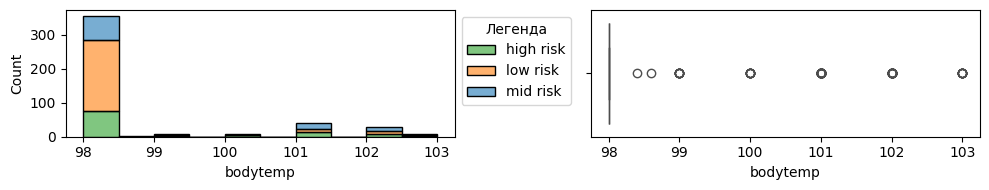

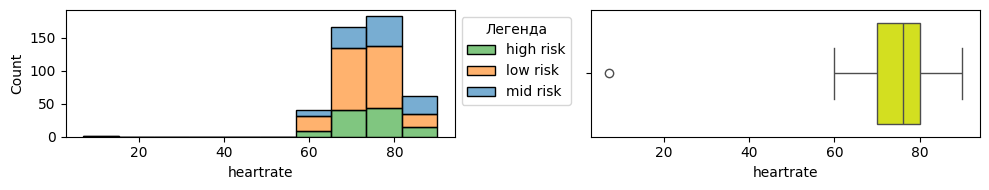

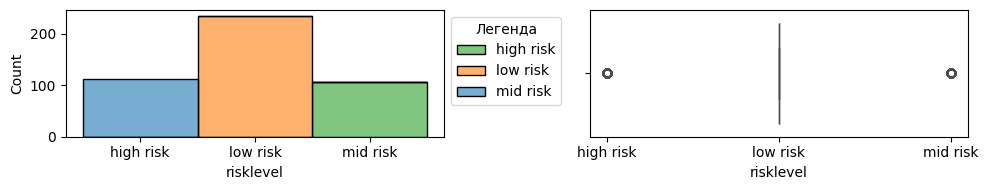

In [7]:
# посмотрим распределения и выбросы по каждому признаку в разбивке по классам целевого признака
for column in data.columns:
    hist_box(data, column, hue='risklevel')


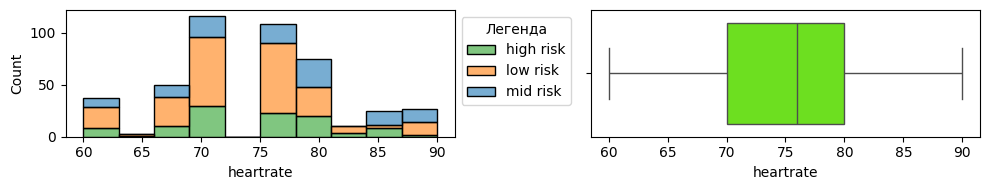

In [8]:
# из всех столбцов аномалия в одном столбце с сердцебиением на уровне 0 - удалим это значение:
data = data[data['heartrate'] > 20]

hist_box(data, 'heartrate', hue='risklevel')

**Вывод**

по итогу загрузки данных - выявили отсутствие пропусков и опечаток в данных, большое количество дубликатов и одну аномалию, которые были удалены, а также скорректировали названия столбцов для удобства обработки. Данные распределены неравномерно - наибольшее количество беременных приходится на естественные возрастные периоды 18-40 лет, при этом в датасете присутствуют данные о беременных женщинах с возрастами - 10-12 лет и старше 60 лет, что скорее аномально -  на это обратили внимание и пользователи оригинального датасета, однако, учитывая небольшой размер датасета, мы не стали удалять эти данные. В целом данные сгруппированы вокруг "нормальных" значений давления, температуры, возраста, сердцебиения. Классы в целевом признаке распределены неравномерно, но данный дисбаланс также естественнен - большее количество женщин с нормальным состоянием, чем с патологиями.

<a id='Генерация-признаков-и-корреляционный-анализ.'></a> 
## Генерация признаков и корреляционный анализ.
[К содержанию](#К-содержанию) 

Сначала попробуем немного расширить набор данных за счет добавления очевидных производных признаков, далее заменим значения целевого признака на порядковые числовые и посмотрим на корреляцию.

In [9]:
# добавим категории по возрасту
def categorize_age(age):
    if age < 25:
        return 1
    elif age <= 34:
        return 2
    elif age <= 44:
        return 3
    elif age <= 54:
        return 4
    elif age <= 64:
        return 5
    else:
        return 6

data['age_category'] = data['age'].apply(categorize_age)

# индексы давления
data['pressure_index'] = (data['systolicbp'] + 2*data['diastolicbp']) / 3

# нормализация признаков для комбинированного индекса
data['bs_norm'] = (data['bs'] - data['bs'].mean()) / data['bs'].std()
data['heartrate_norm'] = (data['heartrate'] - data['heartrate'].mean()) / data['heartrate'].std()
data['systolicbp_norm'] = (data['systolicbp'] - data['systolicbp'].mean()) / data['systolicbp'].std()

# комби индекс
data['combined_index'] = (data['bs_norm'] + data['heartrate_norm'] + data['systolicbp_norm']) / data['age']

# отклонение температуры
data['temp_diff'] = data['bodytemp'] - 98.6

# Возведение уровня сахара в квадрат
data['bs_squared'] = data['bs'] ** 2

# Взаимодействие пульса и давления
data['heartrate_systolicbp_interaction'] = data['heartrate'] * data['systolicbp']

# так как категории в целевом признаке имеют порядковое значение, то можно их закодировать числовыми значениями
encoder = OrdinalEncoder(categories=[['low risk', 'mid risk', 'high risk']])
data['risklevel_encoded'] = encoder.fit_transform(data[['risklevel']]).astype(int)

# удалим вспомогательные столбцы
data = data.drop(columns = ['bs_norm','heartrate_norm','systolicbp_norm','risklevel'],axis=1)

data.head()

,age,systolicbp,diastolicbp,bs,bodytemp,heartrate,age_category,pressure_index,combined_index,temp_diff,bs_squared,heartrate_systolicbp_interaction,risklevel_encoded
0,25,130,80,15.0,98.0,86,2,96.666667,0.200720,-0.6,225.00,11180,2
1,35,140,90,13.0,98.0,70,3,106.666667,0.078460,-0.6,169.00,9800,2
2,29,90,70,8.0,100.0,80,2,76.666667,-0.016780,1.4,64.00,7200,2
3,30,140,85,7.0,98.0,70,2,103.333333,0.020923,-0.6,49.00,9800,2
4,35,120,60,6.1,98.0,76,3,80.000000,-0.000327,-0.6,37.21,9120,0


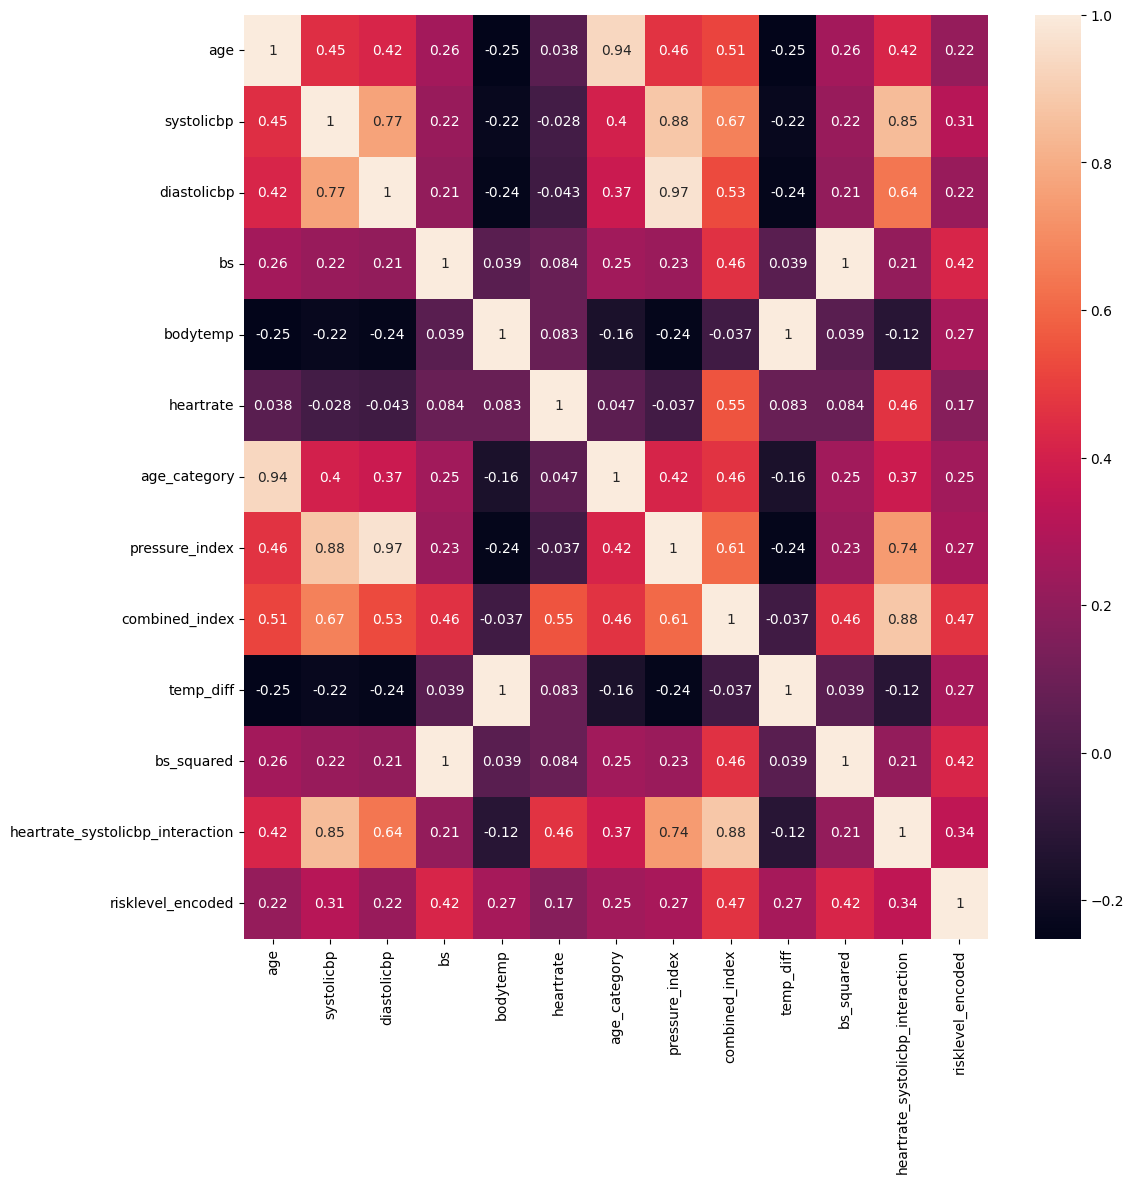

In [10]:
# тк данные распределены ненормально, то построим матрицу корреляции Спирмена
plt.figure(figsize=(12, 12))
sns.heatmap(data.corr(method='spearman'), annot=True)
plt.show()

По таблице корреляции видим, что признаки temp-diff, bs_squared имеют такую же небольшую корреляцию с целевой переменной, как и исходные признаки bodytemp,bs, при этом между собой они мультиколлинераны, поэтому предлагается их исключить:

In [11]:
data = data.drop(columns=['temp_diff','bs_squared'],axis=1)
data.head()

,age,systolicbp,diastolicbp,bs,bodytemp,heartrate,age_category,pressure_index,combined_index,heartrate_systolicbp_interaction,risklevel_encoded
0,25,130,80,15.0,98.0,86,2,96.666667,0.200720,11180,2
1,35,140,90,13.0,98.0,70,3,106.666667,0.078460,9800,2
2,29,90,70,8.0,100.0,80,2,76.666667,-0.016780,7200,2
3,30,140,85,7.0,98.0,70,2,103.333333,0.020923,9800,2
4,35,120,60,6.1,98.0,76,3,80.000000,-0.000327,9120,0


<a id='Разделение данных на обучающую и тестовую выборки'></a> 
## Разделение данных на обучающую и тестовую выборки
[К содержанию](#К-содержанию) 

In [12]:
# зафиксируем константы
RANDOM_STATE = 42

# разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('risklevel_encoded', axis=1),
    data['risklevel_encoded'],
    test_size=0.1,
    random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((405, 10), (46, 10), (405,), (46,))

<a id='Создание моделей и обучение'></a> 
## Создание моделей и обучение
[К содержанию](#К-содержанию) 

In [13]:
# создаём список с названиями количественных признаков
num_columns = X_train.drop(columns=['age_category']).columns

# строим пайплайн с нормализацией и моделями
pipe_base = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_columns)
        ], 
        remainder='passthrough'
    )),
    ('models', 'passthrough')
])


In [14]:
# по метрикам будем ориентироваься на метрику стандартную accuracy (в дальнейшем можно было бы пробовать иные метрики - f1_score, ROC_AUC)

# создадим нейросеть с помощью Keras

def create_model(learning_rate=0.01,random_state=RANDOM_STATE):
    tf.random.set_seed(random_state)
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))  
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# для наглядности создадим отдельные словари с гиперпараметрами для каждой модели

# гиперпараметры для LogisticRegression
param_grid_lr = {
    'models': [LogisticRegression( max_iter=1000, random_state=RANDOM_STATE)],
    'models__C': [0.01, 0.1, 1, 10],
    'models__solver': ['lbfgs', 'saga']
}

# гиперпараметры для CatBoost
param_grid_catboost = {
    'preprocessor__num': ['passthrough'],
    'models': [CatBoostClassifier(verbose=False, random_state=RANDOM_STATE)],
    'models__n_estimators': [150, 300],
    'models__learning_rate': [0.001, 0.1, 1],
    'models__depth': [3, 7]
}

# гиперпараметры для KerasClassifier
param_grid_keras = {
    'models': [KerasClassifier(model=create_model, verbose=2)],
    'models__epochs': [50,100],
    'models__batch_size': [20, 40] 
}

In [16]:
# проводим обучение и кросс-валидацию GridSearch для LogisticRegression
grid_lr = GridSearchCV(pipe_base, param_grid=param_grid_lr, scoring='accuracy', cv=5,verbose=1,n_jobs=-1)
grid_lr.fit(X_train, y_train)

# результаты
print(f"Лучшие параметры: {grid_lr.best_params_}")
print(f"Лучшее значение метрики Accuracy: {grid_lr.best_score_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры: {'models': LogisticRegression(max_iter=1000, random_state=42), 'models__C': 1, 'models__solver': 'saga'}
Лучшее значение метрики Accuracy: 0.6864197530864198


In [17]:
# GridSearch для CatBoost
grid_catboost = GridSearchCV(pipe_base, param_grid=param_grid_catboost, scoring='accuracy', cv=5,verbose=1,n_jobs=-1)
grid_catboost.fit(X_train, y_train)

# результаты
print(f"Лучшие параметры: {grid_catboost.best_params_}")
print(f"Лучшее значение метрики Accuracy: {grid_catboost.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры: {'models': <catboost.core.CatBoostClassifier object at 0x16615d550>, 'models__depth': 7, 'models__learning_rate': 0.001, 'models__n_estimators': 300, 'preprocessor__num': 'passthrough'}
Лучшее значение метрики Accuracy: 0.7259259259259259


In [18]:
# GridSearch для KerasClassifier
grid_keras = GridSearchCV(pipe_base, param_grid=param_grid_keras, scoring='accuracy', cv=5,verbose=2,n_jobs=-1)
grid_keras.fit(X_train, y_train)

# результаты
print(f"Лучшие параметры: {grid_keras.best_params_}")
print(f"Лучшее значение метрики Accuracy: {grid_keras.best_score_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Epoch 1/50
Epoch 1/100
Epoch 1/50
Epoch 1/50
Epoch 1/100
Epoch 1/50
Epoch 1/50
Epoch 1/100
17/17 - 1s - 53ms/step - accuracy: 0.6111 - loss: 0.9162
Epoch 2/50
17/17 - 0s - 2ms/step - accuracy: 0.7006 - loss: 0.7231
Epoch 3/50
17/17 - 1s - 55ms/step - accuracy: 0.5957 - loss: 0.9204
Epoch 2/100
17/17 - 1s - 54ms/step - accuracy: 0.5864 - loss: 0.9632
Epoch 2/50
17/17 - 0s - 2ms/step - accuracy: 0.7346 - loss: 0.6690
Epoch 4/50
17/17 - 1s - 51ms/step - accuracy: 0.6019 - loss: 0.9182
Epoch 2/100
17/17 - 0s - 2ms/step - accuracy: 0.6265 - loss: 0.8119
17/17 - 0s - 2ms/step - accuracy: 0.6821 - loss: 0.7463
Epoch 3/50
Epoch 3/100
17/17 - 0s - 1ms/step - accuracy: 0.7222 - loss: 0.6613
Epoch 5/50
17/17 - 0s - 1ms/step - accuracy: 0.6852 - loss: 0.7855
Epoch 3/100
17/17 - 1s - 51ms/step - accuracy: 0.6142 - loss: 0.8949
Epoch 2/50
17/17 - 1s - 57ms/step - accuracy: 0.5957 - loss: 0.9273
Epoch 2/50
17/17 - 0s - 2ms/step - accuracy: 0

/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


17/17 - 0s - 1ms/step - accuracy: 0.7685 - loss: 0.4713
17/17 - 0s - 1ms/step - accuracy: 0.7778 - loss: 0.4949
Epoch 72/100
Epoch 65/100
17/17 - 0s - 1ms/step - accuracy: 0.7932 - loss: 0.4481
Epoch 74/100
17/17 - 0s - 1ms/step - accuracy: 0.7716 - loss: 0.4948
Epoch 66/100
17/17 - 0s - 1ms/step - accuracy: 0.7963 - loss: 0.4295
Epoch 73/100
17/17 - 0s - 2ms/step - accuracy: 0.7994 - loss: 0.4221
Epoch 75/100
17/17 - 0s - 1ms/step - accuracy: 0.8148 - loss: 0.4443
Epoch 67/100
17/17 - 0s - 1ms/step - accuracy: 0.7840 - loss: 0.4161
Epoch 74/100
17/17 - 0s - 2ms/step - accuracy: 0.7870 - loss: 0.4667
Epoch 76/100
17/17 - 0s - 1ms/step - accuracy: 0.8086 - loss: 0.4315
Epoch 68/100
17/17 - 0s - 1ms/step - accuracy: 0.8086 - loss: 0.4212
Epoch 75/100
17/17 - 0s - 1ms/step - accuracy: 0.8025 - loss: 0.4631
Epoch 77/100
17/17 - 0s - 1ms/step - accuracy: 0.7809 - loss: 0.4619
Epoch 69/100
17/17 - 0s - 1ms/step - accuracy: 0.8210 - loss: 0.4494
Epoch 76/100
17/17 - 0s - 2ms/step - accuracy: 

**Вывод**

по итогу кросс-валидации лучшую метрику Accuracy = 0.73 показала модель, обученная catboost c параметрами: 'models__depth': 7, 'models__learning_rate': 0.001, 'models__n_estimators': 300. Эту модель и будем использовать для предсказания и оценки на тестовой выборке.  
И также выведем матрицу ошибок для этой модели:

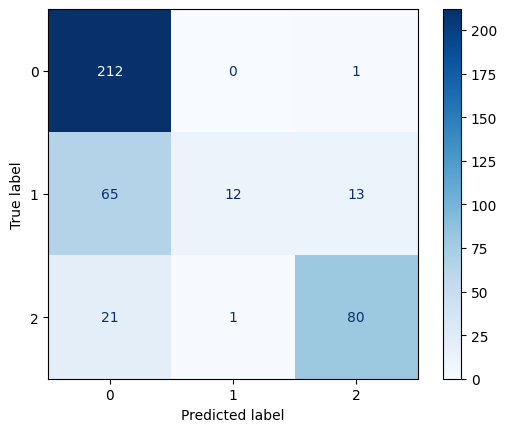

In [19]:
y_pred = grid_catboost.predict(X_train) 
cm_train = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=grid_catboost.classes_)
disp.plot(cmap='Blues');

<a id='Прогноз-на-тестовой-выборке'></a> 
## Прогноз на тестовой выборке
[К содержанию](#К-содержанию) 

In [28]:
# проверим работу отобранной модели на тестовой выборке
y_test_pred = grid_catboost.predict(X_test)
print(f'Метрика Accuracy на тестовой выборке: {accuracy_score(y_test, y_test_pred)}')

Метрика Accuracy на тестовой выборке: 0.6304347826086957


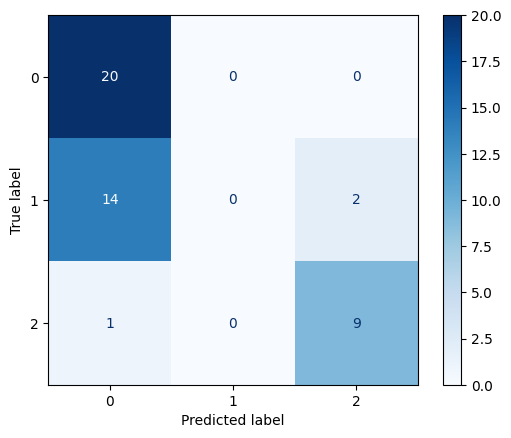

In [29]:
# построим матрицу ошибок
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=grid_catboost.classes_)
disp.plot(cmap='Blues');

In [25]:
y_test.value_counts()

risklevel_encoded
0    20
1    16
2    10
Name: count, dtype: int64

<a id='Общий-вывод'></a> 
## Общий вывод
[К содержанию](#К-содержанию) 

По итогу **загрузки данных** - выявили отсутствие пропусков и опечаток в данных, также выявили большое количество дубликатов и одна аномалия, которые были удалены, далее скорректировали названия столбцов для удобства обработки.   
Данные распределены неравномерно - наибольшее количество беременных приходится на естественные возрастные периоды 18-40 лет, при этом в датасете присутствуют данные о беременных женщинах с возрастами - 10-12 лет и старше 60 лет, что скорее аномально -  на это обратили внимание и пользователи оригинального датасета, однако, учитывая небольшой размер датасета, мы не стали удалять эти данные.  
В целом данные сгруппированы вокруг "нормальных" значений давления, температуры, возраста, сердцебиения. Классы в целевом признаке распределены неравномерно, но данный дисбаланс также естественнен - большее количество женщин с нормальным состоянием, чем с патологиями.

Далее были сгенерированы **дополнительные признаки**, которые могут быть полезны для обучения моделей и дальнейшего прогнозирования, часть из них были удалены в связи с их незначительной корреляцией с целевым признаком и/или мультиколлинеарностью.  

После чего данные были разделены на **обучающую** и **тестовую** выборки, и для обучения моделей были предложены **три типа алгоритмов** - простая логистическая регрессия, ансамблевый алгоритм catboost и нейросеть на базе библиотеки keras. По итогу **кросс-валидации** лучшую метрику **Accuracy = 0.73** показала модель, обученная catboost c параметрами: 'models__depth': 7, 'models__learning_rate': 0.001, 'models__n_estimators': 300. Эту модель отобрали для предсказания и оценки на тестовой выборке. 

На тестовой выборке модель показала **Accuracy = 0.63**, что несколько ниже, чем на кросс-валидации, но в целом неплохой результат с учетом небольшого размера датасета.

При этом **таблица ошибок** как на тренировочных данных, так и на тестовых показала, что модель чаще всего ошибается при предсказании пограничных состояний (средний риск), лучше всего предсказывает низкиу риск, и чуть хуже - высокий риск, что можно обяснить несбалансированностью классов - низкий риск встречается в два раза чаще среднего или высокого, при этом высокий риск имеет явные выбросы в данных, то есть легко выявляется при обучении. А вот средний риск часто определяется как низкий - модель явно переобучается в пользу низкого риска.
